In [1]:
import os
import json

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

data_dir = '/Users/wooyeolbaek/Downloads/ml/input/data/upstage'

In [2]:
train_json = json.load(open(os.path.join(data_dir,'ufo','upstage_annotation_split_ploy.json')))
print(len(train_json['images']))

974


In [3]:
# gt 없는 이미지 따로 빼기
no_gt = set([
    '20210915_190813.jpeg',
])
for img_name in list(train_json['images'].keys()):
    if len(train_json['images'][img_name]['words'])==0:
        no_gt.add(img_name)
print(len(no_gt))

8


In [4]:
for name in no_gt:
    train_json['images'].pop(name)
print(len(train_json['images']))

966


In [6]:
with open(os.path.join(data_dir,'ufo/annotation_clean.json'),'w') as f:
        json.dump(train_json, f, indent=4)

In [7]:
img_names = list(train_json['images'].keys())
img_names

['0F885DC0-3E65-4081-9DBB-CA96BB6FD4FC.JPG',
 '0N8A5655.jpg',
 '0N8A5660.jpg',
 '01.jpg',
 '02.jpg',
 '14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG',
 '20171031_135049.jpg',
 '20171115_221838.jpg',
 '20171129_192902.jpg',
 '20171204_143202.jpg',
 '20171208_190335.jpg',
 '20171230_134905.jpg',
 '20180123_124551.jpg',
 '20180327_124210.jpg',
 '20180328_211233.jpg',
 '20180329_163802.jpg',
 '20180330_102822.jpg',
 '20180330_102849.jpg',
 '20180330_102907.jpg',
 '20180330_103036.jpg',
 '20180330_103128.jpg',
 '20180330_103134.jpg',
 '20180330_103201.jpg',
 '20180508_123253.jpg',
 '20180514_114954.jpg',
 '20180601_164446.jpg',
 '20180717_121803.jpg',
 '20180717_121841.jpg',
 '20180728_142342.jpg',
 '20180805_153039.jpg',
 '20180815_170113.jpg',
 '20180815_172431.jpg',
 '20180815_173540.jpg',
 '20180822_171754.jpg',
 '20180823_134449.jpg',
 '20180915_170630.jpg',
 '20180915_185217.jpg',
 '20180921_205435_001.jpg',
 '20181004_184646.jpg',
 '20181012_122118.jpg',
 '20181023_194810.jpg',
 '20181031

In [17]:
img_names = list(train_json['images'].keys())
pred_color = (0,0,255)
gt_color = (0,122,122)

cands = defaultdict(set)

for i,img_name in tqdm(enumerate(img_names[:])):
    img = cv2.imread(os.path.join(data_dir,'images',img_name))

    dense = len(train_json['images'][img_name]['words'].keys()) > 40

    for key, value in train_json['images'][img_name]['words'].items():
        if value['transcription']=='###':
            continue

        points = [[int(p[0]),int(p[1])] for p in value['points']]
        
        x0,y0 = points[0]
        x1,y1 = points[1]
        x2,y2 = points[2]
        x3,y3 = points[3]

        hor = ((x0-x3)**2 + (y0-y3)**2) <= ((x0-x1)**2 + (y0-y1)**2)
        ver = ((x0-x3)**2 + (y0-y3)**2) > ((x0-x1)**2 + (y0-y1)**2)
        ratio = ((x0-x3)**2 + (y0-y3)**2) / ((x0-x1)**2 + (y0-y1)**2 + 1e-3) # ratio < 1: ver, ratio > 1: hor

        tan = abs((y2-y0)/(x2-x0+1e-4)) # 1/2<tan<np.sqrt(3)/2
        fourth = x0<x2 and y0<y2 and 2+np.sqrt(3)>tan>(np.sqrt(6)+np.sqrt(2))/2 # 시계방향으로 90도 이하로 돌아간 경우 -> 일반적인 경우(거의 대부분 여기 속함)
        first = x0<x2 and y0>y2 and 2+np.sqrt(3)>tan>(np.sqrt(6)+np.sqrt(2))/2 # 반시계방향으로 90-180 정도 돌아간 경우 -> 오른쪽으로 갈수록 심하게 올라가는 글씨

        third = x0>x2 and y0<y2 # 시계방향으로 90-180 정도 돌아간 경우 -> 뒤집혀서 오른쪽으로 갈수록 올라가는 글씨 -> 글자가 안돌아가 있으면 말도 안되게 작은 글씨들이나 순서 잘못 찍힌 Polygon인듯
        second = x0>x2 and y0>y2 # 반시계 방향으로 90 이하로 돌아간 경우 -> 뒤집혀서 오른쪽으로 갈수록 내려가는 글씨(없음)

        img_w = train_json['images'][img_name]['img_w']
        img_h = train_json['images'][img_name]['img_h']
        size_ratio = np.sqrt(((x0-x3)**2 + (y0-y3)**2) * ((x0-x1)**2 + (y0-y1)**2)) / (img_w * img_h)

        if dense:
            cands['dense'].add(img_name)

        if 'poly' in train_json['images'][img_name]['tags']:
            cands['poly'].add(img_name)


        if first:
            cands['first'].add(img_name)
        elif second:
            cands['second'].add(img_name)
        elif third:
            cands['third'].add(img_name)
        elif fourth:
            cands['fourth'].add(img_name)

        if size_ratio < 1/10000:
            cands['small'].add(img_name)
        elif size_ratio > 2500/10000:
            cands['large'].add(img_name)

        if ratio > 5:
            cands['vertical'].add(img_name)
        elif ratio < 10/1000:
            cands['horizontal'].add(img_name)


#print(cands)

24it [00:05,  3.59it/s]Invalid SOS parameters for sequential JPEG
966it [04:06,  3.92it/s]


In [18]:
for k,v in cands.items():
    print(k,len(v))

fourth 314
vertical 353
dense 184
horizontal 112
second 52
small 270
third 136
first 29
large 9


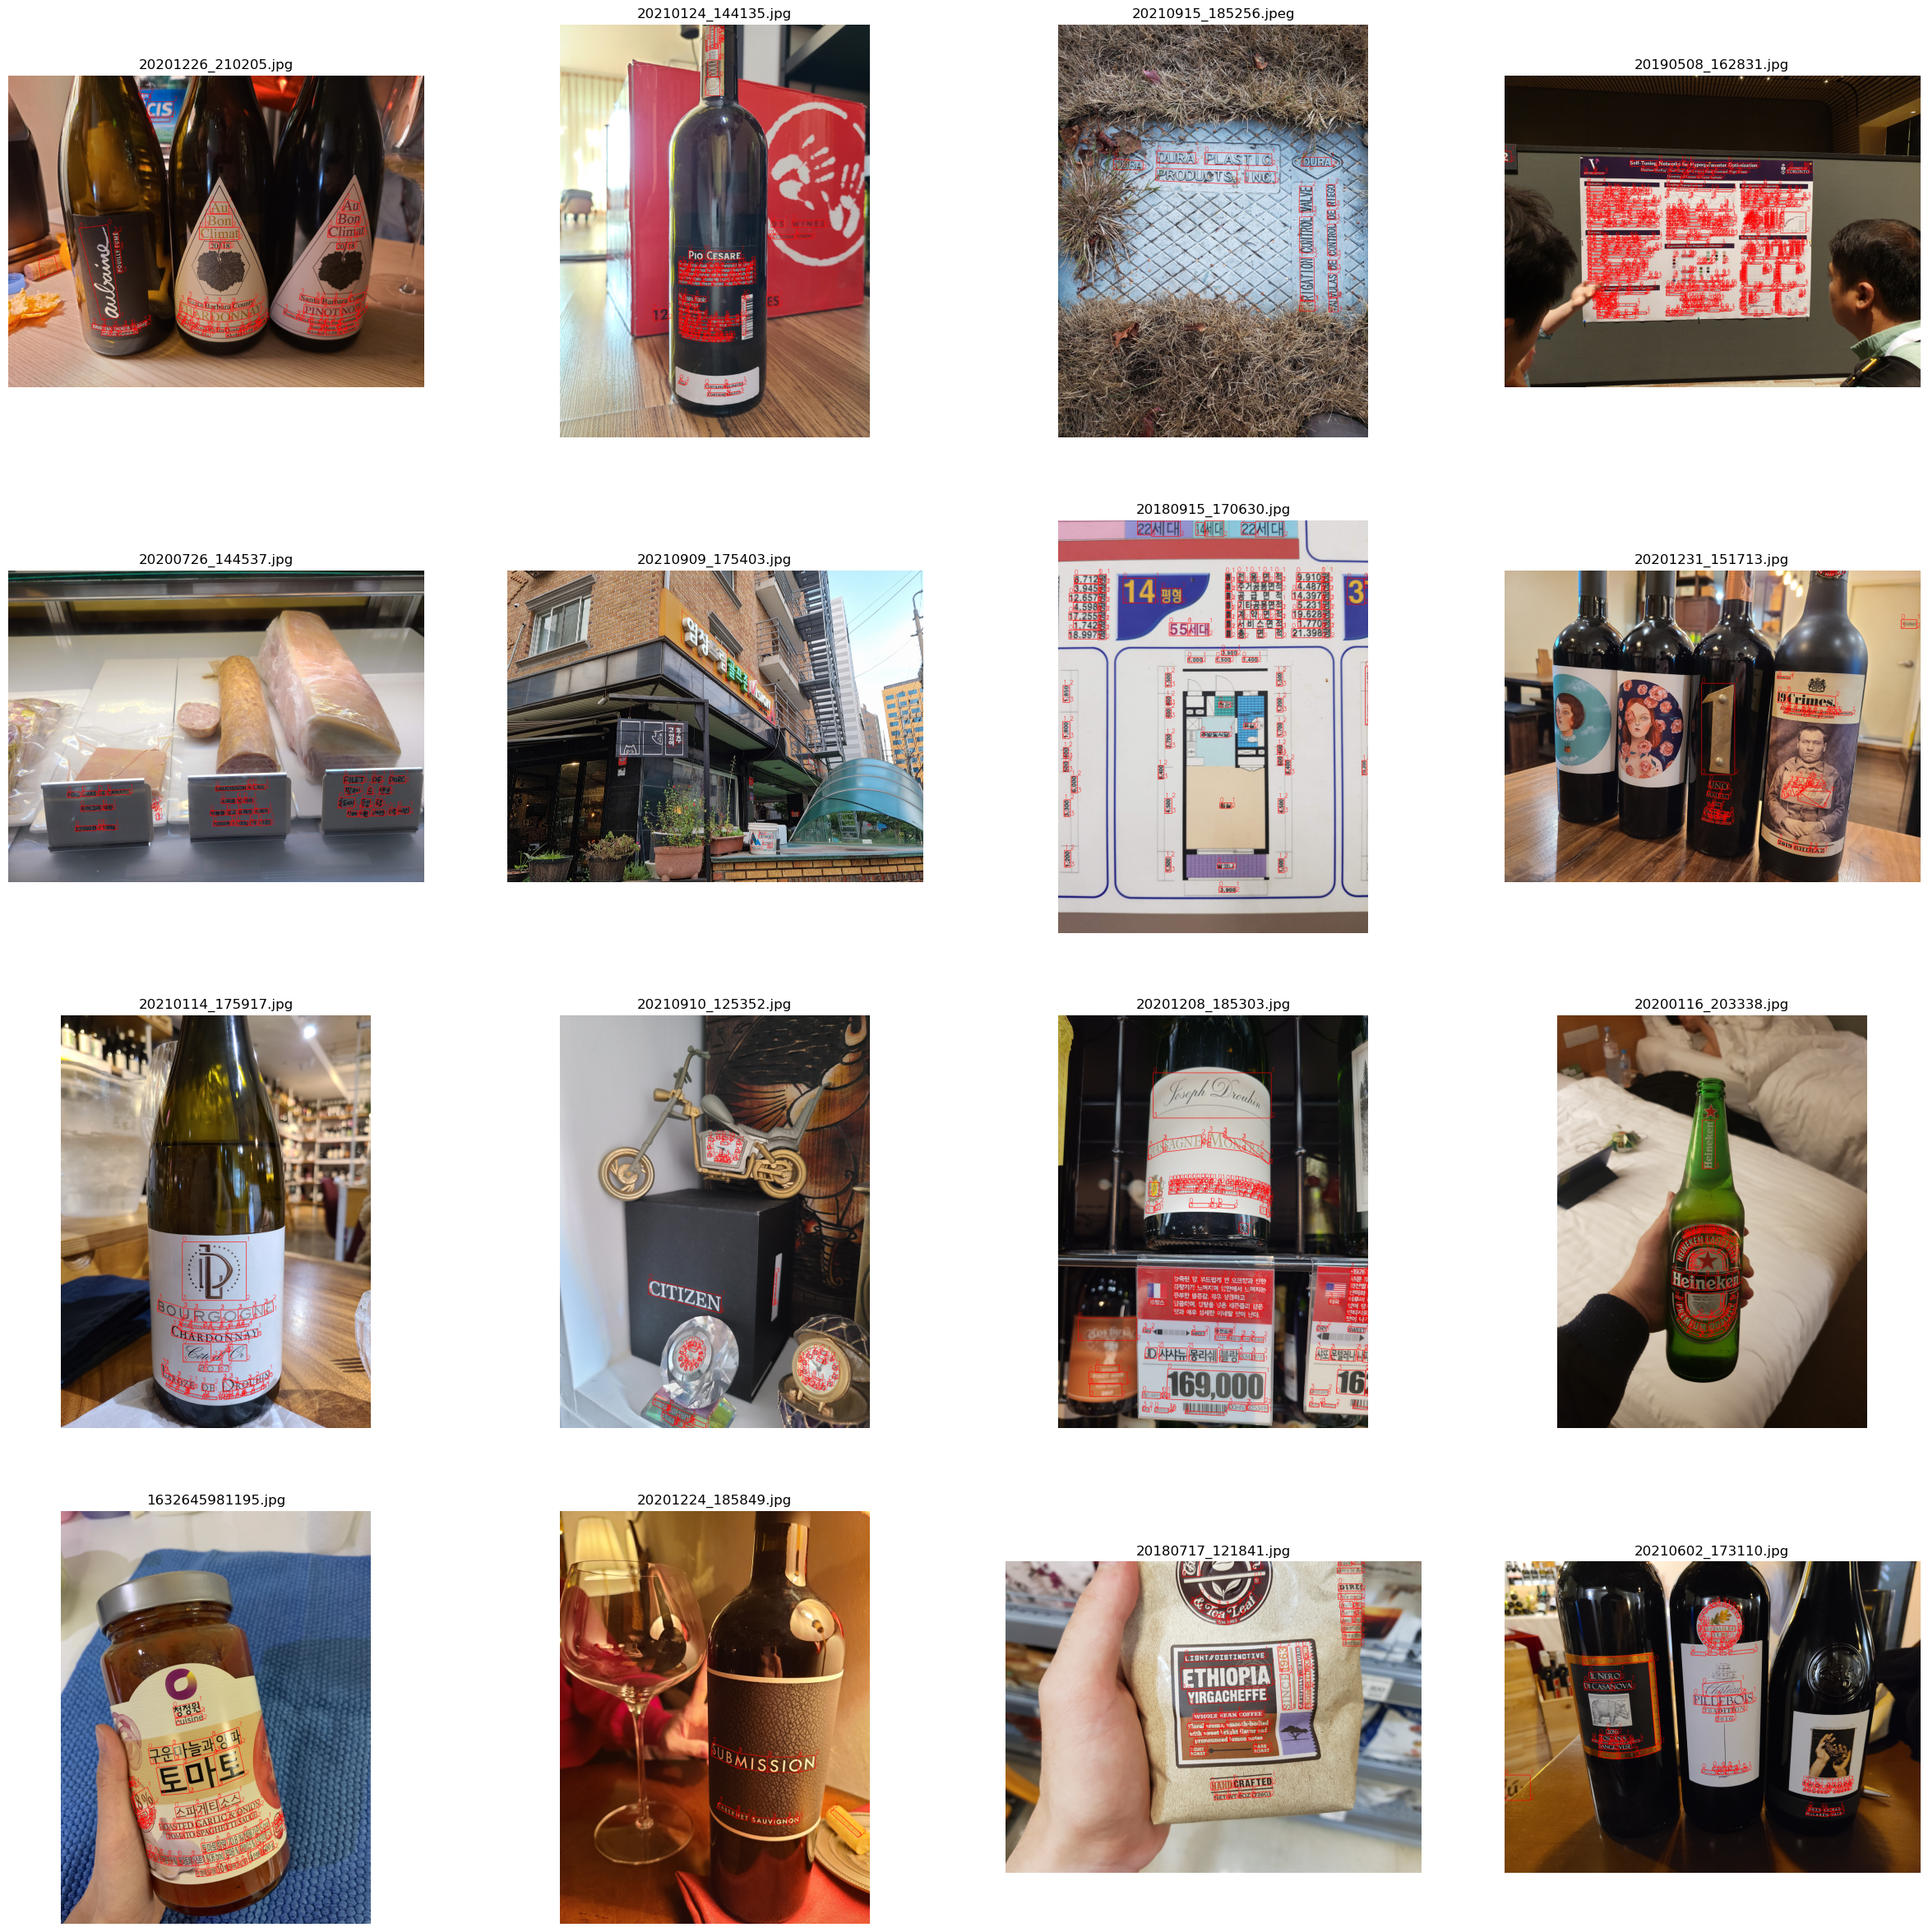

In [23]:
img_names = list(cands['first'])[:16]

gt_color = (0,0,255)
none_color = (122,122,122)

fig, axes = plt.subplots(4,4,figsize=(30,30))

for i,img_name in enumerate(img_names):
    img = cv2.imread(os.path.join(data_dir,'images',img_name))

    for key, value in train_json['images'][img_name]['words'].items():
        points = np.array([[int(p[0]),int(p[1])] for p in value['points']])
        language = value['language']

        if value['transcription']!='###':
            color = gt_color
        else:
            color = none_color


        img = cv2.polylines(img, [points], True, pred_color, 3)
        cv2.putText(img,"0",(points[0][0],points[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)
        cv2.putText(img,"1",(points[1][0],points[1][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)
        cv2.putText(img,"2",(points[2][0],points[2][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)
        cv2.putText(img,"3",(points[3][0],points[3][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

    
    axes[i//4,i%4].set_title(img_name)
    axes[i//4,i%4].plot()
    axes[i//4,i%4].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    axes[i//4,i%4].axis('off')


In [130]:
# 저장할 특징들
features = set([
    'small',
    'large',
    'dense',
    'vertical',
    'horizontal',
])

targets = set()
for feature in features:
    targets = targets | cands[feature]


file_name = '_'.join(features)

# 특징별 json 저장
save_dir = f'/opt/ml/input/data/upstage/ufo/upstage_{file_name}.json'

# 저장할 json 객체 생성
new_json = {}
new_json['images'] = {}
new_json['version'] = {}
new_json['tags'] = {}

for img_name in valid:
    new_json['images'][img_name] = train_json['images'][img_name]


In [131]:
new_json['images']

{'1632645507275-0.jpg': {'paragraphs': {},
  'words': {'0001': {'transcription': 'CLAUDE',
    'points': [[135.1118301802221, 544.0512647445014],
     [406.62417433701523, 544.0512647445014],
     [406.62417433701523, 594.8762355718815],
     [135.1118301802221, 594.8762355718814]],
    'orientation': 'Horizontal',
    'language': ['en'],
    'tags': [],
    'confidence': None,
    'illegibility': False},
   '0002': {'transcription': 'MONET',
    'points': [[139.57016095455364, 600.2262325010793],
     [382.5491881556246, 600.2262325010793],
     [382.5491881556245, 648.3762048638604],
     [139.57016095455364, 648.3762048638604]],
    'orientation': 'Horizontal',
    'language': ['en'],
    'tags': [],
    'confidence': None,
    'illegibility': False},
   '0003': {'transcription': '&',
    'points': [[389.236684317122, 601.5637317333789],
     [435.6033243701704, 601.5637317333789],
     [435.6033243701703, 647.4845387089941],
     [389.2366843171219, 647.4845387089941]],
    'orient

In [132]:
# 저장
with open('/opt/ml/input/data/upstage/ufo/upstage_valid.json','w') as f:
        json.dump(new_json, f, indent=4)